In [1]:
import javabridge
import os
import glob
import pandas as pd
import pydot
from IPython.display import SVG

In [2]:
tetrad_libdir = os.path.join(os.getcwd(), '../../', 'src', 'pycausal', 'lib')
for l in glob.glob(tetrad_libdir + os.sep + "*.jar"):
    print (l)
    javabridge.JARS.append(str(l))

/home/jovyan/py-causal/example/javabridge/../../src/pycausal/lib/causal-cmd-1.0.0-jar-with-dependencies.jar


In [3]:
javabridge.start_vm(run_headless=True, max_heap_size = '100M')
javabridge.attach()

In [4]:
data_dir = os.path.join(os.getcwd(),os.getcwd(), '..','..','data', 'audiology.txt')
data_dir

'/home/jovyan/py-causal/example/javabridge/../../data/audiology.txt'

In [5]:
dframe = pd.read_table(data_dir, sep="\t")
dframe.head()

,age_gt_60,air,airBoneGap,ar_c,ar_u,bone,boneAbnormal,bser,history_buzzing,history_dizziness,...,s_sn_gt_2k,s_sn_gt_4k,speech,static_normal,tymp,viith_nerve_signs,wave_V_delayed,waveform_ItoV_prolonged,indentifier,class
0,f,mild,f,normal,normal,?,t,?,f,f,...,f,f,normal,t,a,f,f,f,p1,cochlear_unknown
1,f,moderate,f,normal,normal,?,t,?,f,f,...,f,f,normal,t,a,f,f,f,p2,cochlear_unknown
2,t,mild,t,?,absent,mild,t,?,f,f,...,f,f,normal,t,as,f,f,f,p3,mixed_cochlear_age_fixation
3,t,mild,t,?,absent,mild,f,?,f,f,...,f,f,normal,t,b,f,f,f,p4,mixed_cochlear_age_otitis_media
4,t,mild,f,normal,normal,mild,t,?,f,f,...,f,f,good,t,a,f,f,f,p5,cochlear_age


In [6]:
dataBox = javabridge.JClassWrapper("edu.cmu.tetrad.data.VerticalIntDataBox")(len(dframe.index),dframe.columns.size)

In [7]:
node_list = javabridge.JClassWrapper("java.util.ArrayList")()
# load dataset
col_no = 0
for col in dframe.columns:
    
    cat_array = sorted(set(dframe[col]))
    cat_list = javabridge.JClassWrapper("java.util.ArrayList")()

    for cat in cat_array:
        cat = str(cat)
        cat_list.add(cat)
        
    nodi = javabridge.JClassWrapper("edu.cmu.tetrad.data.DiscreteVariable")(col, cat_list)
    node_list.add(nodi)
    
    for row in dframe.index:
        value = javabridge.JClassWrapper("java.lang.Integer") (cat_array.index(dframe.iloc[row,col_no]))
        dataBox.set(row,col_no,value)
    
    col_no = col_no + 1

In [8]:
boxData = javabridge.JClassWrapper("edu.cmu.tetrad.data.BoxDataSet")(dataBox, node_list)

In [9]:
alpha = 0.05
indTest = javabridge.JClassWrapper('edu.cmu.tetrad.search.IndTestChiSquare')(boxData, alpha)

In [10]:
score = javabridge.JClassWrapper("edu.cmu.tetrad.search.BDeuScore")(boxData)
score.setStructurePrior(1.0)
score.setSamplePrior(1.0)

In [11]:
gfci = javabridge.JClassWrapper('edu.cmu.tetrad.search.GFci')(indTest, score)

In [12]:
gfci.setMaxDegree(3)
gfci.setMaxPathLength(-1)
gfci.setCompleteRuleSetUsed(False)
gfci.setFaithfulnessAssumed(True)
gfci.setVerbose(True)

In [13]:
prior = javabridge.JClassWrapper('edu.cmu.tetrad.data.Knowledge2')()
prior.setForbidden('history_noise','class') # forbidden directed edges
prior.setForbidden('history_fluctuating','class') # forbidden directed edges
prior.setTierForbiddenWithin(0, True)
prior.addToTier(0, 'class')
prior.addToTier(0, 'history_fluctuating')
prior.addToTier(0, 'history_noise')
gfci.setKnowledge(prior)
prior

Instance of edu.cmu.tetrad.data.Knowledge2: /knowledge
addtemporal

1*  class history_fluctuating history_noise

forbiddirect

requiredirect

In [14]:
tetradGraph = gfci.search()
tetradGraph

Instance of edu.cmu.tetrad.graph.EdgeListGraphSingleConnections: Graph Nodes:
age_gt_60;air;airBoneGap;ar_c;ar_u;bone;boneAbnormal;bser;history_buzzing;history_dizziness;history_fluctuating;history_fullness;history_heredity;history_nausea;history_noise;history_recruitment;history_ringing;history_roaring;history_vomiting;late_wave_poor;m_at_2k;m_cond_lt_1k;m_gt_1k;m_m_gt_2k;m_m_sn;m_m_sn_gt_1k;m_m_sn_gt_2k;m_m_sn_gt_500;m_p_sn_gt_2k;m_s_gt_500;m_s_sn;m_s_sn_gt_1k;m_s_sn_gt_2k;m_s_sn_gt_3k;m_s_sn_gt_4k;m_sn_2_3k;m_sn_gt_1k;m_sn_gt_2k;m_sn_gt_3k;m_sn_gt_4k;m_sn_gt_500;m_sn_gt_6k;m_sn_lt_1k;m_sn_lt_2k;m_sn_lt_3k;middle_wave_poor;mod_gt_4k;mod_mixed;mod_s_mixed;mod_s_sn_gt_500;mod_sn;mod_sn_gt_1k;mod_sn_gt_2k;mod_sn_gt_3k;mod_sn_gt_4k;mod_sn_gt_500;notch_4k;notch_at_4k;o_ar_c;o_ar_u;s_sn_gt_1k;s_sn_gt_2k;s_sn_gt_4k;speech;static_normal;tymp;viith_nerve_signs;wave_V_delayed;waveform_ItoV_prolonged;indentifier;class

Graph Edges:
1. history_fluctuating --> history_recruitment dd nl
2. history

In [15]:
tetradGraph.toString()

'Graph Nodes:\nage_gt_60;air;airBoneGap;ar_c;ar_u;bone;boneAbnormal;bser;history_buzzing;history_dizziness;history_fluctuating;history_fullness;history_heredity;history_nausea;history_noise;history_recruitment;history_ringing;history_roaring;history_vomiting;late_wave_poor;m_at_2k;m_cond_lt_1k;m_gt_1k;m_m_gt_2k;m_m_sn;m_m_sn_gt_1k;m_m_sn_gt_2k;m_m_sn_gt_500;m_p_sn_gt_2k;m_s_gt_500;m_s_sn;m_s_sn_gt_1k;m_s_sn_gt_2k;m_s_sn_gt_3k;m_s_sn_gt_4k;m_sn_2_3k;m_sn_gt_1k;m_sn_gt_2k;m_sn_gt_3k;m_sn_gt_4k;m_sn_gt_500;m_sn_gt_6k;m_sn_lt_1k;m_sn_lt_2k;m_sn_lt_3k;middle_wave_poor;mod_gt_4k;mod_mixed;mod_s_mixed;mod_s_sn_gt_500;mod_sn;mod_sn_gt_1k;mod_sn_gt_2k;mod_sn_gt_3k;mod_sn_gt_4k;mod_sn_gt_500;notch_4k;notch_at_4k;o_ar_c;o_ar_u;s_sn_gt_1k;s_sn_gt_2k;s_sn_gt_4k;speech;static_normal;tymp;viith_nerve_signs;wave_V_delayed;waveform_ItoV_prolonged;indentifier;class\n\nGraph Edges:\n1. history_fluctuating --> history_recruitment dd nl\n2. history_recruitment --> m_sn_gt_1k dd nl\n3. history_roaring --> h

In [16]:
tetradGraph.getNodeNames()

Instance of java.util.ArrayList: [age_gt_60, air, airBoneGap, ar_c, ar_u, bone, boneAbnormal, bser, history_buzzing, history_dizziness, history_fluctuating, history_fullness, history_heredity, history_nausea, history_noise, history_recruitment, history_ringing, history_roaring, history_vomiting, late_wave_poor, m_at_2k, m_cond_lt_1k, m_gt_1k, m_m_gt_2k, m_m_sn, m_m_sn_gt_1k, m_m_sn_gt_2k, m_m_sn_gt_500, m_p_sn_gt_2k, m_s_gt_500, m_s_sn, m_s_sn_gt_1k, m_s_sn_gt_2k, m_s_sn_gt_3k, m_s_sn_gt_4k, m_sn_2_3k, m_sn_gt_1k, m_sn_gt_2k, m_sn_gt_3k, m_sn_gt_4k, m_sn_gt_500, m_sn_gt_6k, m_sn_lt_1k, m_sn_lt_2k, m_sn_lt_3k, middle_wave_poor, mod_gt_4k, mod_mixed, mod_s_mixed, mod_s_sn_gt_500, mod_sn, mod_sn_gt_1k, mod_sn_gt_2k, mod_sn_gt_3k, mod_sn_gt_4k, mod_sn_gt_500, notch_4k, notch_at_4k, o_ar_c, o_ar_u, s_sn_gt_1k, s_sn_gt_2k, s_sn_gt_4k, speech, static_normal, tymp, viith_nerve_signs, wave_V_delayed, waveform_ItoV_prolonged, indentifier, class]

In [17]:
tetradGraph.getEdges()

Instance of java.util.HashSet: [bone o-o o_ar_u, tymp o-o airBoneGap, m_m_sn_gt_2k o-o notch_4k, late_wave_poor o-o middle_wave_poor, m_sn_lt_1k o-> history_fluctuating, ar_c o-o o_ar_c, notch_at_4k o-o history_noise, history_dizziness o-> history_roaring, history_fluctuating --> history_recruitment dd nl, speech o-> air, history_heredity o-o s_sn_gt_2k, late_wave_poor o-o bser, static_normal o-o history_dizziness, wave_V_delayed o-o history_buzzing, history_roaring --> history_nausea dd nl, ar_u o-o airBoneGap, o_ar_u o-o ar_c, notch_at_4k o-o class, ar_u o-o o_ar_c, history_vomiting o-> history_roaring, history_dizziness o-> history_fluctuating, tymp o-o class, history_recruitment --> m_sn_gt_1k dd nl, m_m_sn o-o age_gt_60, airBoneGap o-> air, waveform_ItoV_prolonged o-o static_normal, age_gt_60 o-o class, boneAbnormal o-o bone, history_buzzing o-o history_fullness]

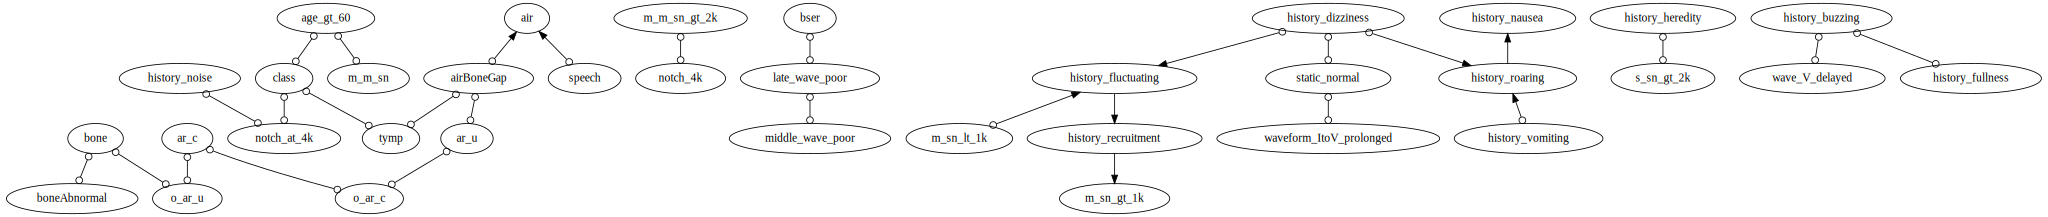

In [18]:
dot_str = javabridge.static_call('edu/cmu/tetrad/graph/GraphUtils',
                                   'graphToDot',
                                   '(Ledu/cmu/tetrad/graph/Graph;)Ljava/lang/String;', 
                                   tetradGraph)
graphs = pydot.graph_from_dot_data(dot_str)
svg_str = graphs[0].create_svg()
SVG(svg_str)

In [19]:
javabridge.detach()
javabridge.kill_vm()